In [1]:
# 2022/01/17: This computes just the entropy deviation being significant, 
# ignoring the pressure deviation since it's the implied shape of the star

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pickle
sys.path.append(os.environ['rapp'])
sys.path.append(os.environ['raco'])
sys.path.append(os.environ['rapl'])
from common import *
from plotcommon import *
sys.path.append(os.environ['rapl'] + '/azav')
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
csfont = {'fontname':'DejaVu Serif'}
ticklabelsize = 10
plt.rcParams['xtick.labelsize'] = ticklabelsize
plt.rcParams['ytick.labelsize'] = ticklabelsize

import sys, os
from azav_util import plot_azav_half

In [2]:
# Get Rachel's solar data
di = get_dict('/mizar/loma3853/fixedflux/paperplots/gongdata/avgong.pkl')
Om = di['om']*1e-9*(2*np.pi) # nHz --> rad/s
rr = di['rr']*rsun
tt = di['tt']

cost = np.cos(tt)
sint = np.sin(tt)
nt = len(cost)
cost_2d = cost.reshape((nt, 1))
sint_2d = sint.reshape((nt, 1))

In [3]:
# look at r
rr

array([6.96193947e+10, 6.96020022e+10, 6.95832183e+10, 6.95603298e+10,
       6.95294407e+10, 6.94894379e+10, 6.94397650e+10, 6.93787521e+10,
       6.93034078e+10, 6.92087926e+10, 6.90872538e+10, 6.89275210e+10,
       6.87120628e+10, 6.84282867e+10, 6.80789062e+10, 6.76584251e+10,
       6.71572428e+10, 6.65714634e+10, 6.58996955e+10, 6.51402694e+10,
       6.42911675e+10, 6.33503029e+10, 6.23150317e+10, 6.11827799e+10,
       5.99502082e+10, 5.86137686e+10, 5.71694258e+10, 5.56124492e+10,
       5.39370644e+10, 5.21369407e+10, 5.02045644e+10, 4.81366657e+10,
       4.59567593e+10, 4.36766721e+10, 4.12993261e+10, 3.88242342e+10,
       3.62477788e+10, 3.35640465e+10, 3.07658715e+10, 2.78460882e+10,
       2.48004527e+10, 2.16318175e+10, 1.83538183e+10, 1.50028401e+10,
       1.16941604e+10, 8.69896323e+09, 6.25519871e+09, 4.31282518e+09,
       2.70508335e+09, 1.29888581e+09, 0.00000000e+00])

In [4]:
# Let's remove the r-values beyond two_cutoffs rmin and rmax
#ircut = np.argmin(np.abs(rr - 4.176e10))
rr = di['rr']*rsun
Om = di['om']*1e-9*(2*np.pi) # nHz --> rad/s

rin = 5e10
rout = 6.5860209e10

#rmax = rout/rsun
rmax = 0.99
rmin = rin/rsun
#rmin = 0.7
#rmin = rin/rsun

irmin = np.argmin(np.abs(rr/rsun - rmin))
irmax = np.argmin(np.abs(rr/rsun - rmax))

rr = rr[irmax:irmin+1]
nr = len(rr)
rr_2d = rr.reshape((1, nr))

Om = Om[:, irmax:irmin+1]

print(rr)
print(nr)
print(np.shape(Om))

[6.89275210e+10 6.87120628e+10 6.84282867e+10 6.80789062e+10
 6.76584251e+10 6.71572428e+10 6.65714634e+10 6.58996955e+10
 6.51402694e+10 6.42911675e+10 6.33503029e+10 6.23150317e+10
 6.11827799e+10 5.99502082e+10 5.86137686e+10 5.71694258e+10
 5.56124492e+10 5.39370644e+10 5.21369407e+10 5.02045644e+10]
20
(49, 20)


In [5]:
dOmdr = drad(Om, rr)
dOmdt = dth(Om, tt)
dOmdz = cost_2d*dOmdr - sint_2d*dOmdt/rr_2d
dOmdl = sint_2d*dOmdr + cost_2d*dOmdt/rr_2d

In [6]:
# read in model S
fname_S = 'modelS.txt'
modelS = np.loadtxt(fname_S, skiprows=6)
print(np.shape(modelS))

(2482, 6)


In [7]:
rr_ref = modelS[:, 0]*rsun
cs_ref = modelS[:, 1]
rho_ref = modelS[:, 2]
P_ref = modelS[:, 3]
gam_ref = modelS[:, 4]
T_ref = modelS[:, 5]

In [8]:
# integrate the density to get M(r), and hence g(r) = GM(r)/r^2
from scipy.integrate import simps
mass = np.zeros_like(rho_ref)
fp = 4*np.pi
integrand = rho_ref*fp*rr_ref**2

nr_ref = len(rr_ref)
for ir in range(nr_ref):
    mass[ir] = -simps(integrand[ir:], rr_ref[ir:])
print ('mass from integral:', mass[0])

mass from integral: 1.9865271445677947e+33


<IPython.core.display.Javascript object>


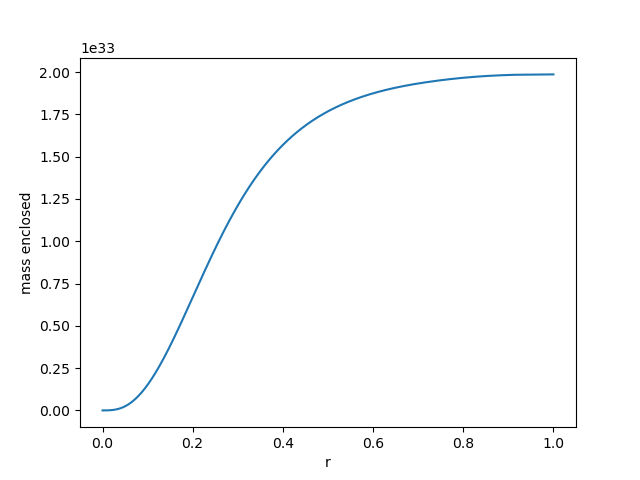

Text(0, 0.5, 'mass enclosed')

In [9]:
plt.figure()
plt.plot(rr_ref/rsun, mass)
plt.xlabel('r')
plt.ylabel('mass enclosed')

<IPython.core.display.Javascript object>


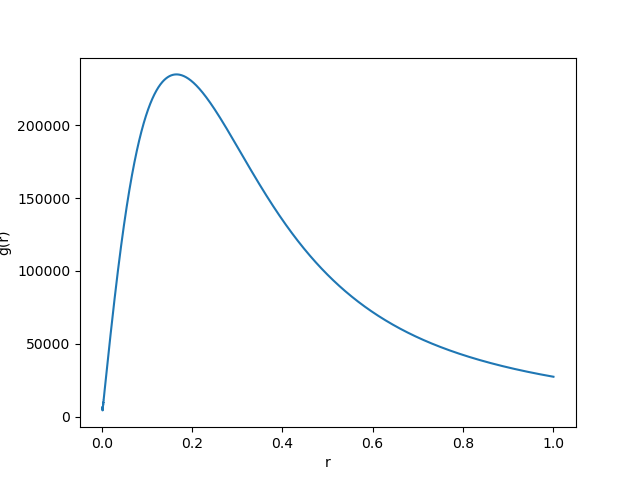

/home5/loma3853/miniconda3/envs/custom/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, 'g(r)')

In [10]:
plt.figure()
g_ref = G*mass/rr_ref**2
plt.plot(rr_ref/rsun, g_ref)
plt.xlabel('r')
plt.ylabel('g(r)')

In [11]:
from scipy.interpolate import interp1d
# first interpolate density
f = interp1d(rr_ref, rho_ref)
rho = f(rr)

# then interpolate gravity
f = interp1d(rr_ref, g_ref)
g = f(rr)

<IPython.core.display.Javascript object>


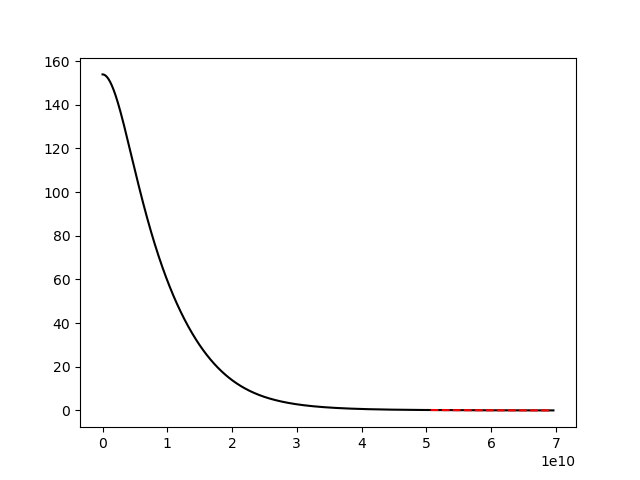

In [12]:
# Plot the interpolation to make sure it worked
plt.figure()
plt.plot(rr_ref, rho_ref, 'k')
plt.plot(rr, rho, 'r--')

<IPython.core.display.Javascript object>


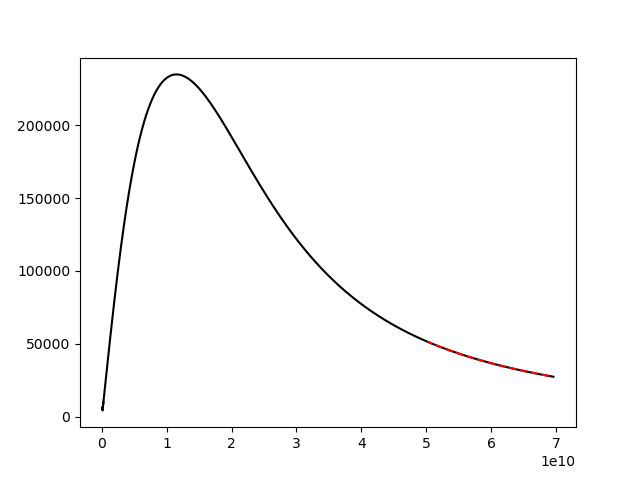

In [13]:
plt.figure()
plt.plot(rr_ref, g_ref, 'k')
plt.plot(rr, g, 'r--')
plt.show()

<IPython.core.display.Javascript object>


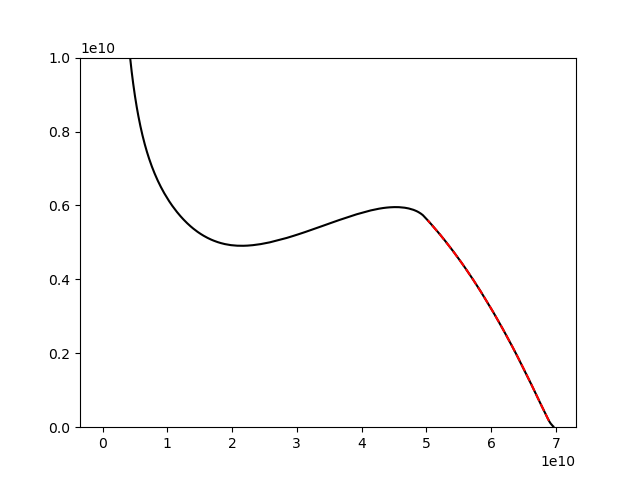

(0.0, 10000000000.0)

In [14]:
# Sweet...also interpolate pressure, temp, and define cP, pressure scale height
cp = 3.4e8

# get pressure scale height
dlnP_ref = np.gradient(P_ref, rr_ref)/P_ref
Hp_ref = -1./dlnP_ref
f = interp1d(rr_ref, Hp_ref)
Hp = f(rr)

f = interp1d(rr_ref, P_ref)
P = f(rr)

f = interp1d(rr_ref, dlnP_ref)
dlnP = f(rr)
dPdr = dlnP*P

# see what pressure scale height looks like
plt.figure()
plt.plot(rr_ref, Hp_ref, 'k')
plt.plot(rr, Hp, 'r--')
plt.ylim(0,1e10)

In [15]:
# Solve (non-D) thermal wind equation
#dPdt = (rr_2d**2)*Om**2*sint_2d*cost_2d/g/Hp
dSdt = 2*Om*rr_2d**2*sint_2d*dOmdz/g

In [16]:
tt

array([1.5708   , 1.53807  , 1.50535  , 1.47262  , 1.4399   , 1.40717  ,
       1.37445  , 1.34172  , 1.309    , 1.27627  , 1.24355  , 1.21082  ,
       1.1781   , 1.14537  , 1.11265  , 1.07992  , 1.0472   , 1.01447  ,
       0.981748 , 0.949023 , 0.916298 , 0.883573 , 0.850848 , 0.818123 ,
       0.785398 , 0.752673 , 0.719948 , 0.687223 , 0.654499 , 0.621774 ,
       0.589049 , 0.556324 , 0.523599 , 0.490874 , 0.458149 , 0.425424 ,
       0.392699 , 0.359974 , 0.327249 , 0.294524 , 0.261799 , 0.229074 ,
       0.19635  , 0.163625 , 0.1309   , 0.0981748, 0.0654498, 0.0327249,
       0.       ])

In [17]:
# The latitudes are ~linearly spaced (thanks Rachel!) 
# Let's do Simpson integration from the equator
# to get S
from scipy.integrate import simps
nt = len(tt)
# Integrate S
S_dev = np.zeros((nt, nr))
for ir in range(nr):
    dSdt_loc = dSdt[:, ir]
    for it in range(nt):
        S_dev[it, ir] = simps(dSdt_loc[:it+1], tt[:it+1])

In [18]:
# Get the temperature too ... assume it's along constant P-surfaces
gam = 5./3.
T_dev = S_dev

In [19]:
print(np.shape(T_dev))
print(np.shape(rr))

(49, 20)
(20,)


In [20]:
# compute the dimensional thermo variables
# interpolate temperature
f = interp1d(rr_ref, T_ref)
T = f(rr)

S_dev_dim = S_dev*cp
T_dev_dim = T_dev*T.reshape((1, nr))

<IPython.core.display.Javascript object>


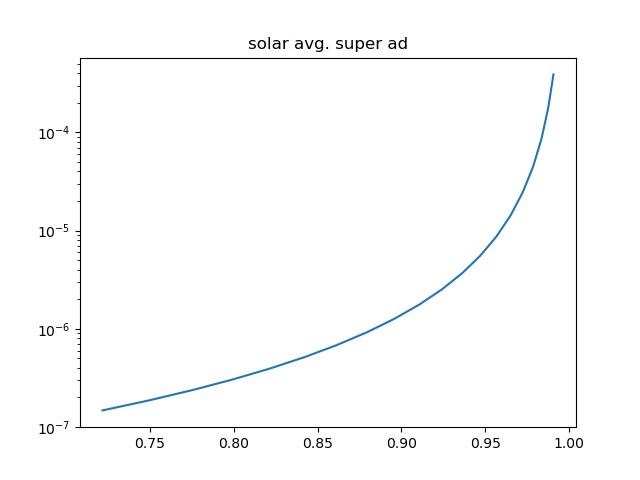

Text(0.5, 1.0, 'solar avg. super ad')

In [21]:
# compute the expected superadiabatic gradient for the solar CZ
flux_sun = lsun/(4*np.pi*rr**2)
superad = (flux_sun/(rho**0.5*P**0.5*cp*T))**(2/3)
plt.figure()
plt.plot(rr/rsun, superad)
plt.yscale('log')
#plt.xlim(0.7,.95)
#plt.ylim(0,5e-8)
plt.title('solar avg. super ad')

<IPython.core.display.Javascript object>


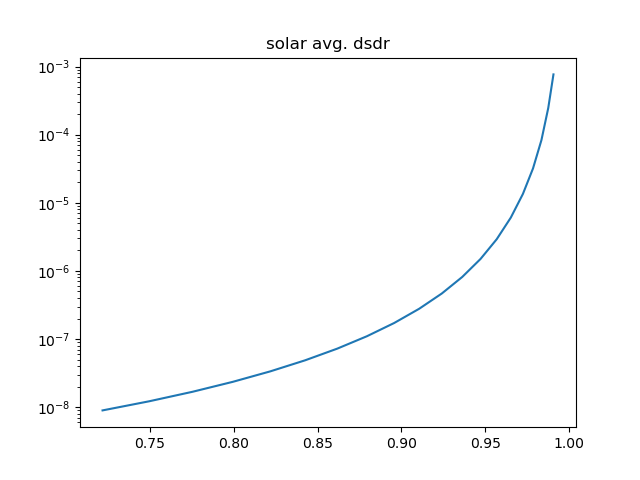

In [22]:
# maybe just plot dSdr
dsdr_superad = -(flux_sun*cp**0.5*(-dPdr)**1.5/(rho**0.5*P**2*T))**(2/3)
plt.figure()
plt.plot(rr/rsun, np.abs(dsdr_superad))
plt.title('solar avg. dsdr')
#plt.ylim(0, 1e-3)
plt.yscale('log')

In [23]:
help(make_figure)

Help on function make_figure in module plotcommon:

make_figure(**kwargs)



<IPython.core.display.Javascript object>


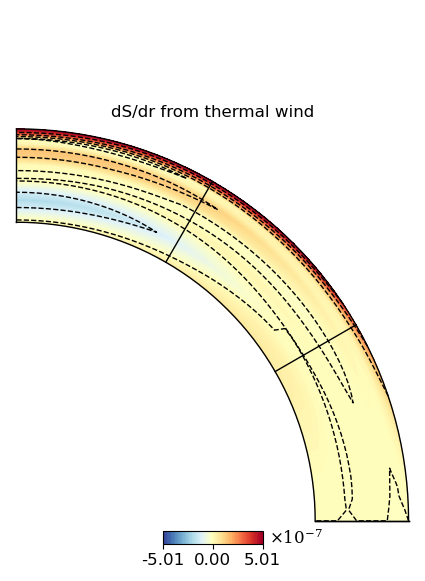

got here


Text(0.5, 1.0, 'dS/dr from thermal wind')

In [24]:
# plot dSdr from the thermal wind
pltmax = 0.95
irplotmax = np.argmin(np.abs(rr/rsun-pltmax))
dSdr = drad(S_dev_dim, rr)
fig, axs, fapr = make_figure(sub_width_inches=4, sub_aspect=1)
ax = axs[0,0]
# plot dSdr
plot_azav_half(dSdr[:, irplotmax:], rr[irplotmax:], cost, fig=fig,ax=ax)
ax.set_title ('dS/dr from thermal wind')

In [25]:
# function to average over radius
def avgrad(arr, r1, r2):
    ir1 = np.argmin(np.abs(rr/rsun - r1))
    ir2 = np.argmin(np.abs(rr/rsun - r2))
    rr_cut = rr[ir2:ir1+1]
    if arr.ndim == 1:
        return np.sum((rr_cut**2*arr[ir2:ir1+1]))/np.sum((rr_cut**2))
    if arr.ndim == 2:
        print (ir1, ir2)
        return np.sum(rr_cut**2*arr[:, ir2:ir1+1], axis=1)/np.sum(rr_cut**2)    

def get_rind(r1, r2):
    ir1 = np.argmin(np.abs(rr/rsun - r1))
    ir2 = np.argmin(np.abs(rr/rsun - r2))
    rr_cut = rr[ir2:ir1+1]
    return ir1, ir2, rr_cut

In [26]:
# compute total dSdr
dsdr_tot = dsdr_superad.reshape((1, nr)) + dSdr

<IPython.core.display.Javascript object>


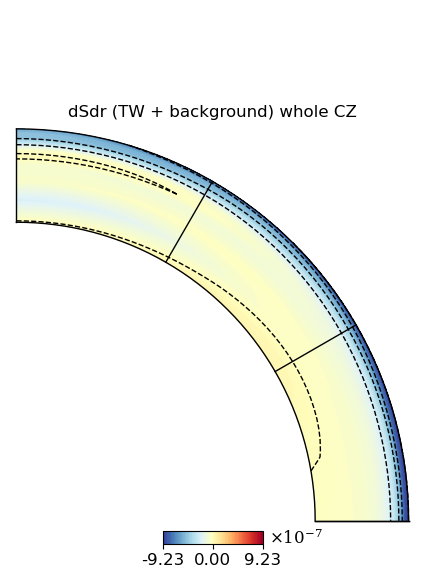

got here


Text(0.5, 1.0, 'dSdr (TW + background) whole CZ')

In [27]:
# total entropy gradient (spherical mean + thermal wind)
# plot in whole CZ
fig, axs, fapr = make_figure(sub_width_inches=4, sub_aspect=1)
ax = axs[0,0]

# plot dSdr
r1 = 0.72
r2 = 0.95
minmax = -2.5e-7, 2.5e-7
minmax = None
ir1, ir2, rr_cut = get_rind(r1, r2)

plot_azav_half(dsdr_tot[:, ir2:ir1+1], rr_cut, cost, fig=fig,ax=ax,minmax=minmax)
ax.set_title('dSdr (TW + background) whole CZ')

<IPython.core.display.Javascript object>


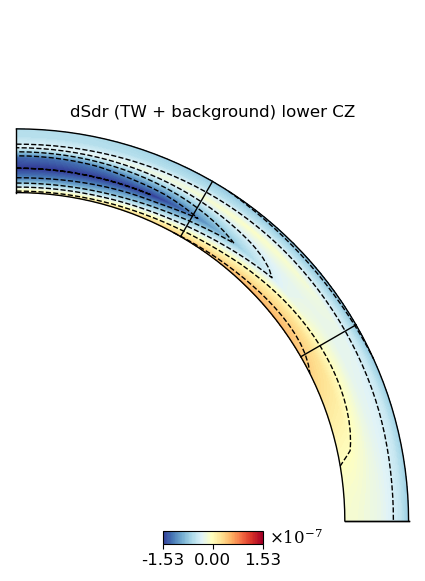

got here


Text(0.5, 1.0, 'dSdr (TW + background) lower CZ')

In [28]:
# total entropy gradient (spherical mean + thermal wind)
# plot in lower CZ
fig, axs, fapr = make_figure(sub_width_inches=4, sub_aspect=1)
ax = axs[0,0]

# plot dSdr
r1 = 0.72
r2 = 0.86
minmax = None
ir1, ir2, rr_cut = get_rind(r1, r2)

plot_azav_half(dsdr_tot[:, ir2:ir1+1], rr_cut, cost, fig=fig,ax=ax,minmax=minmax)
ax.set_title('dSdr (TW + background) lower CZ')

<IPython.core.display.Javascript object>


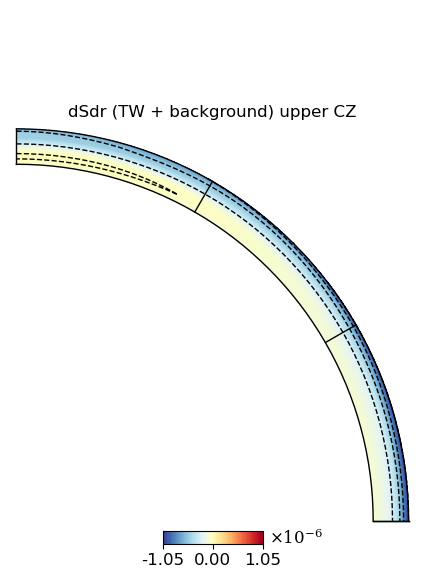

got here


Text(0.5, 1.0, 'dSdr (TW + background) upper CZ')

In [29]:
# total entropy gradient (spherical mean + thermal wind)
# plot in upper CZ
fig, axs, fapr = make_figure(sub_width_inches=4, sub_aspect=1)
ax = axs[0,0]

# plot dSdr
r1 = 0.86
r2 = 0.95
minmax = None
ir1, ir2, rr_cut = get_rind(r1, r2)

plot_azav_half(dsdr_tot[:, ir2:ir1+1], rr_cut, cost, fig=fig,ax=ax,minmax=minmax)
ax.set_title('dSdr (TW + background) upper CZ')

19 7


<IPython.core.display.Javascript object>


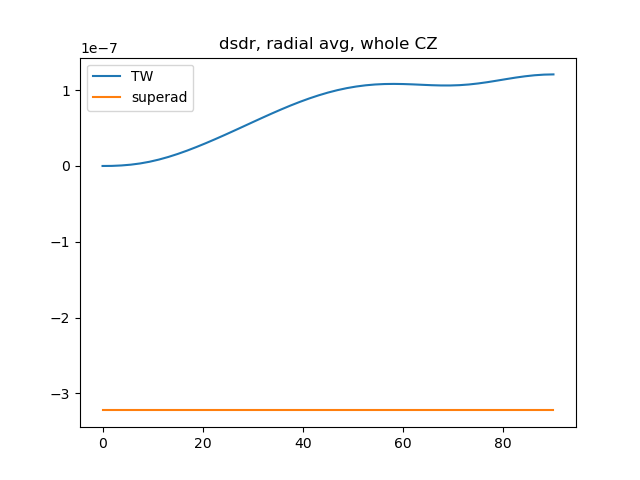

In [30]:
# let's average the mixing length flux over the whole CZ
r1, r2 = 0.72, 0.95
dsdr_whole = avgrad(dSdr, r1, r2)
tt_lat = 90 - 180*tt/np.pi
plt.figure()
plt.plot(tt_lat, dsdr_whole, label='TW')
plt.plot(tt_lat, avgrad(dsdr_superad, r1, r2) + np.zeros(nt), label='superad')
plt.title('dsdr, radial avg, whole CZ')
plt.legend()

19 13


<IPython.core.display.Javascript object>


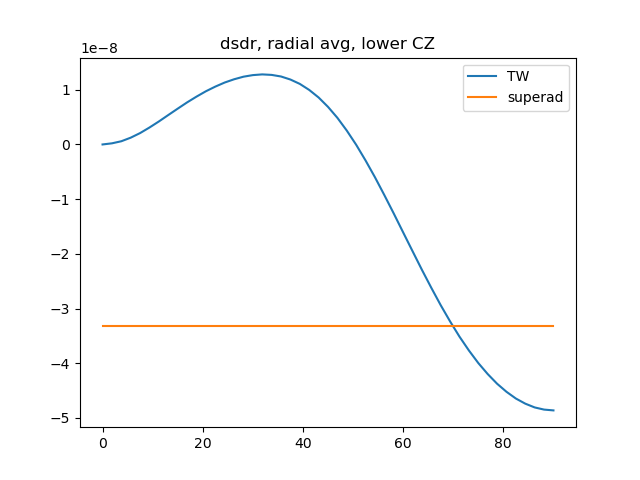

In [31]:
# let's average the mixing length flux over the lower CZ
r1, r2 = 0.72, 0.86
dsdr_lower = avgrad(dSdr, r1, r2)
tt_lat = 90 - 180*tt/np.pi
plt.figure()
plt.plot(tt_lat, dsdr_lower, label='TW')
plt.plot(tt_lat, avgrad(dsdr_superad, r1, r2) + np.zeros(nt), label='superad')
plt.title('dsdr, radial avg, lower CZ')
plt.legend()

13 7


<IPython.core.display.Javascript object>


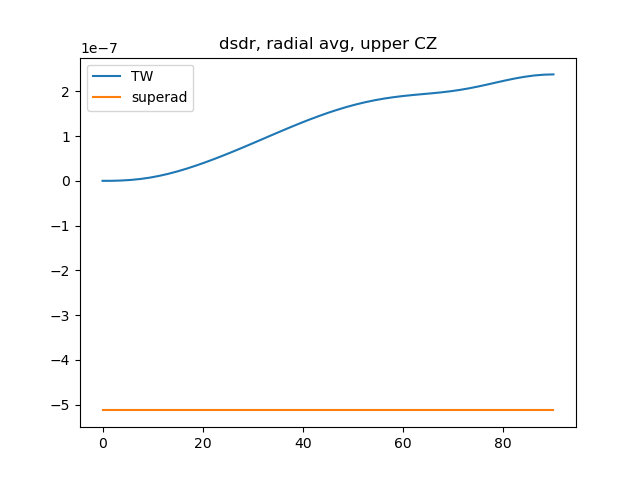

In [32]:
# let's average the mixing length flux over the upper CZ
r1, r2 = 0.86, 0.95
dsdr_upper = avgrad(dSdr, r1, r2)
tt_lat = 90 - 180*tt/np.pi
plt.figure()
plt.plot(tt_lat, dsdr_upper, label='TW')
plt.plot(tt_lat, avgrad(dsdr_superad, r1, r2) + np.zeros(nt), label='superad')
plt.title('dsdr, radial avg, upper CZ')
plt.legend()

<IPython.core.display.Javascript object>


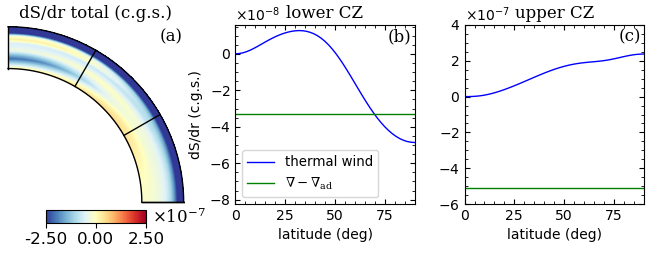

got here


In [33]:
# make thesis figure
# total dSdr , two line plots for upper and lower CZ

# Make figure
fig_width_inches = 6.5
margin_inches = 1/16
margin_top_inches = 1/4
margin_bottom_inches = 1/2
margin_left_inches = 1/2
subplot_width_inches = (fig_width_inches - 2*margin_inches - 2*margin_left_inches)/3
subplot_height_inches = subplot_width_inches
fig_height_inches = 1*(subplot_height_inches + margin_bottom_inches) + margin_top_inches

fig_aspect = fig_height_inches/fig_width_inches
margin_x = margin_inches/fig_width_inches
margin_y = margin_inches/fig_height_inches
margin_top = margin_top_inches/fig_height_inches
margin_bottom = margin_bottom_inches/fig_height_inches
margin_left = margin_left_inches/fig_width_inches

subplot_width = subplot_width_inches/fig_width_inches
subplot_height = subplot_height_inches/fig_height_inches
   
fig = plt.figure(figsize=(fig_width_inches, fig_height_inches))

ax1 = fig.add_axes((margin_x, 1 - margin_top - subplot_height, subplot_width, subplot_height))   
ax2 = fig.add_axes((margin_left + 1*(subplot_width + margin_x),\
                    1 - margin_top - subplot_height, subplot_width, subplot_height))

ax3 = fig.add_axes((margin_x + 2*(subplot_width + margin_left),\
                    1 - margin_top - subplot_height, subplot_width, subplot_height))

fs = 10

# Ignore part of NSSL...things will go crazy

r1 = 0.72
r2 = 0.95
minmax = -2.5e-7, 2.5e-7
#minmax = None
ir1, ir2, rr_cut = get_rind(r1, r2)


plot_azav_half(dsdr_tot[:, ir2:ir1+1], rr_cut, cost, fig=fig,ax=ax1,minmax=minmax,\
              plotcontours=False)

# make the line plots
dsdr_back = avgrad(dsdr_superad, 0.72, 0.86) + np.zeros(nt)
lineplot(tt_lat, [dsdr_lower, dsdr_back], ax2,\
         labels=['thermal wind', r'$\nabla - \nabla_{\rm{ad}}$'],\
         fontsize=fs, ncolleg=1, plotleg=True,\
         xlabel='latitude (deg)', ylabel='dS/dr (c.g.s.)')

dsdr_back = avgrad(dsdr_superad, 0.86, 0.95) + np.zeros(nt)
lineplot(tt_lat, [dsdr_upper, dsdr_back], ax3,\
         labels=['thermal wind', r'$\nabla - \nabla_{\rm{ad}}$'],\
         fontsize=fs, ncolleg=1, plotleg=False,\
         xlabel='latitude (deg)', minmax=(-6e-7, 4e-7))

# Label the plots with (a), (b), ...
fs = 12
fig.text(margin_x + subplot_width - margin_x/2, 1 - margin_top - margin_y/2, '(a)',\
         va='top', ha='right', **csfont, fontsize=fs)
fig.text(margin_x + subplot_width - margin_x/2 + 1*(margin_left + subplot_width),\
         1 - margin_top - margin_y/2, '(b)',\
         va='top', ha='right', **csfont, fontsize=fs)
fig.text(margin_x + subplot_width - margin_x/2 + 2*(margin_left + subplot_width),\
         1 - margin_top - margin_y/2, '(c)',\
         va='top', ha='right', **csfont, fontsize=fs)


# Label the top with the thermal variable
fig.text(margin_x + 0.5*subplot_width, 1 - margin_top + margin_y/2,\
         'dS/dr total (c.g.s.)',\
         fontsize=fs, **csfont, ha='center', va='bottom')
fig.text(margin_left + 0.5*subplot_width + 1*(subplot_width + margin_x),\
         1 - margin_top + margin_y/2,\
         'lower CZ',\
         fontsize=fs, **csfont, ha='center', va='bottom')
fig.text(margin_x + 0.5*subplot_width + 2*(subplot_width + margin_left),\
         1 - margin_top + margin_y/2,\
         'upper CZ',\
         fontsize=fs, **csfont, ha='center', va='bottom')

plt.savefig('thermo_merplane_thesis.png', dpi=300)
#plt.savefig('thermo_merplane_Sun_withNSSL.png', dpi=300)

<IPython.core.display.Javascript object>


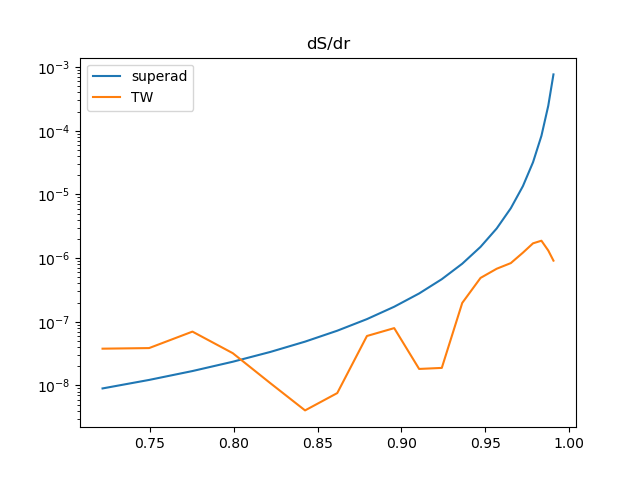

In [34]:
# plot the average dS/dr from TW and the superad
plt.figure()
plt.plot(rr/rsun, np.abs(dsdr_superad), label = 'superad')
plt.plot(rr/rsun, np.mean(np.abs(dSdr),axis=0), label = 'TW')
plt.legend()
plt.title('dS/dr')
#plt.ylim(0, 1e-3)
plt.yscale('log')